# Voyager, by Rizky Indrabayu

## Import all necessary libraries

In [55]:
import pandas as pd
import numpy as np
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
from tabgan.sampler import OriginalGenerator, GANGenerator
import sklearn
import lightgbm as lgb
from xgboost import XGBClassifier
import pickle

### Read all data, but we only used 2.8M loan activity data, due to computational resources

In [2]:
train = pd.read_csv('datathon-2024/ristek-datathon-2024/ristek-datathon-2024/train.csv')
test = pd.read_csv('datathon-2024/ristek-datathon-2024/ristek-datathon-2024/test.csv')
loan_activities = pd.read_csv('datathon-2024/ristek-datathon-2024/ristek-datathon-2024/loan_activities.csv').dropna().sample(n=2800000, random_state=9)
non_borrower_user = pd.read_csv('datathon-2024/ristek-datathon-2024/ristek-datathon-2024/non_borrower_user.csv')

,user_id,reference_contact,loan_type,ts
1378147,2523652,1960629,4,443
1153763,1717443,3164116,4,738
4279492,1090823,1404162,11,353
1886281,44914,1849631,5,743
531377,1795170,2430354,3,759
...,...,...,...,...
323662,3654301,1057661,1,323
1602603,635678,2038392,5,522
3065270,3268502,1877087,5,412
1438192,1349357,3260768,4,390


## EDA

#### The distribution is very high imbalanced

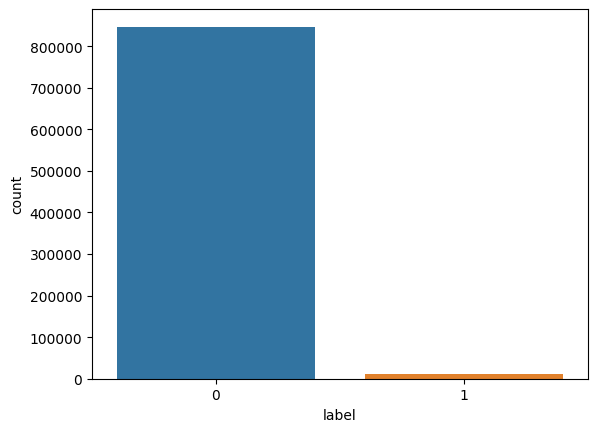

In [3]:
ax = sns.countplot(x=train['label'])

### Apply GAN for augmented data, here we choose the best approach correspond to their ROC-AUC score

In [38]:
def fit_predict(clf, X_train, y_train, X_test, y_test):
    clf.fit(X_train, y_train)
    
    return sklearn.metrics.roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])

clf = sklearn.ensemble.RandomForestClassifier(n_estimators=25, max_depth=6)
sample = train.sample(n=10_000, random_state=17)

X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(sample.drop(columns=['label']), sample[['label']], test_size=0.2, random_state=42)
new_features1, new_label1 = OriginalGenerator().generate_data_pipe(X_train, y_train, test,)
new_features2, new_label2 = GANGenerator().generate_data_pipe(X_train, y_train, test,)

[LightGBM] [Info] Number of positive: 19016, number of negative: 19016
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000682 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1540
[LightGBM] [Info] Number of data points in the train set: 38032, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with pos

KeyboardInterrupt: 

In [5]:
print("initial metric", fit_predict(clf, X_train, y_train, X_test, y_test))
print("OriginalGenerator metric", fit_predict(clf, new_features1, new_label1, X_test, y_test))
print("GANGenerator metric", fit_predict(clf, new_features2, new_label2, X_test, y_test))

initial metric 0.6463017657520326
OriginalGenerator metric 0.6506923272357724
GANGenerator metric 0.5792444740853658


### Based on the ROC-AUC score above, we choose OgirinalGenerator

In [56]:
new_features, new_label = OriginalGenerator().generate_data_pipe(train.drop(columns=['label']), train[['label']], test, use_adversarial=True)

[LightGBM] [Info] Number of positive: 294162, number of negative: 294161
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009210 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1571
[LightGBM] [Info] Number of data points in the train set: 588323, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500001 -> initscore=0.000003
[LightGBM] [Info] Start training from score 0.000003
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

### Merge original data with augmented data

In [57]:
augmented = pd.concat([new_features, new_label], axis=1)
new_train = pd.concat([train, augmented], axis=0)
new_train = new_train.sample(frac=1).reset_index(drop=True)

new_train[['label']].value_counts()

label
0        3366855
1          43289
Name: count, dtype: int64

In [58]:
df_majority = new_train[new_train.label == 0]
df_minority = new_train[new_train.label == 1]

df_majority_undersampled = df_majority.sample(n=len(df_minority), random_state=42)
df_balanced = pd.concat([df_majority_undersampled, df_minority])
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

### Feature Engineering based on pc[0-16] and Building Graph dataset 

In [59]:
def feature_engineering(df):
    df['feature_sum'] = df[[f'pc{i}' for i in range(17)]].sum(axis=1)
    return df

df_balanced = feature_engineering(df_balanced)
test = feature_engineering(test)
non_borrower_user = feature_engineering(non_borrower_user)
loan_activities['ts'] = pd.to_datetime(loan_activities['ts'])

loan_features = loan_activities.groupby('user_id').agg({
    'loan_type': 'nunique',
    'ts': ['count', lambda x: (x.max() - x.min()).days]
}).reset_index()
loan_features.columns = ['user_id', 'loan_type_count', 'loan_count', 'loan_span']

df_balanced = df_balanced.merge(loan_features, on='user_id', how='left').fillna(0)
test = test.merge(loan_features, on='user_id', how='left').fillna(0)

In [60]:
G = nx.Graph()
G.add_edges_from(loan_activities[['user_id', 'reference_contact']].values)

def add_graph_features(df, G):
    df['degree'] = df['user_id'].apply(lambda x: G.degree(x) if x in G else 0)
    df['closeness'] = df['user_id'].apply(lambda x: nx.closeness_centrality(G, x) if x in G else 0)
    return df

df_balanced = add_graph_features(df_balanced, G)
test = add_graph_features(test, G)

### Feature Selection and using 90% Train & 10% Test data

In [61]:
X = df_balanced.drop(columns=['user_id', 'label'])
y = df_balanced[['label']]

In [62]:
X_train, X_val, y_train, y_val = sklearn.model_selection.train_test_split(X, y, test_size=0.1, random_state=42)

### 1. Train on RandomForest

In [63]:
# Train model
model = sklearn.ensemble.RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Evaluate model
y_pred = model.predict(X_val)
print(sklearn.metrics.classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.76      0.84      4348
           1       0.80      0.94      0.86      4310

    accuracy                           0.85      8658
   macro avg       0.86      0.85      0.85      8658
weighted avg       0.86      0.85      0.85      8658



### 2. Train on LightGBM

In [64]:
clf = lgb.LGBMClassifier()
clf.fit(X_train, y_train)

predictions = clf.predict(X_val)

classification_rep = sklearn.metrics.classification_report(predictions, y_val)
print(classification_rep)

[LightGBM] [Info] Number of positive: 38979, number of negative: 38941
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002353 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3913
[LightGBM] [Info] Number of data points in the train set: 77920, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500244 -> initscore=0.000975
[LightGBM] [Info] Start training from score 0.000975
              precision    recall  f1-score   support

           0       0.65      0.77      0.71      3681
           1       0.80      0.70      0.75      4977

    accuracy                           0.73      8658
   macro avg       0.73      0.73      0.73      8658
weighted avg       0.74      0.73      0.73      8658



### 3. Train on XGBoost

In [65]:
xgb = XGBClassifier()
xgb.fit(X_train, y_train)

predictions = xgb.predict(X_val)

classification_rep = sklearn.metrics.classification_report(predictions, y_val)
print(classification_rep)

              precision    recall  f1-score   support

           0       0.67      0.83      0.74      3516
           1       0.86      0.72      0.79      5142

    accuracy                           0.77      8658
   macro avg       0.77      0.78      0.76      8658
weighted avg       0.78      0.77      0.77      8658



### Based on the performance above, we selected LightGBM as ML model

In [69]:
predictions = clf.predict(test.drop(columns=['user_id']))

### Make submission

In [70]:
submission = pd.DataFrame({
    'user_id': test['user_id'],
    'label': predictions
})

In [35]:
submission

,user_id,label
0,4,1
1,13,1
2,37,0
3,61,0
4,66,0
...,...,...
367697,3700510,1
367698,3700517,1
367699,3700526,0
367700,3700539,0


In [71]:
submission.to_csv('submission.csv', index=False)

### Save Model

In [72]:
pickle.dump(clf, open('model.pkl', 'wb'))

In [73]:
import pathlib
import pkg_resources

installed_packages = {pkg.key for pkg in pkg_resources.working_set}

# Menyimpan nama library beserta versi yang digunakan ke file requirements.txt
with open('requirements.txt', 'w') as f:
    for package in sorted(installed_packages):
        version = pkg_resources.get_distribution(package).version
        f.write(f"{package}=={version}\n")